In [1]:
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse.linalg

##  Первое задание. Предобусловленный метод сопряженных градиентов.

Задача, решить линейную систему:
$$
Ax = b
$$

Где $A$ -  матрица оператора Лапласа, $b$ константный вектор.



$$
\begin{equation}
A =  \frac{1}{h^2}
\begin{pmatrix}
2 & -1 & \cdots & 0 &0 \\
-1 & 2 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots & \vdots & \vdots \\
0 & 0& \cdots &-2 & 1 \\
0 & 0& \cdots &-1 & 1
\end{pmatrix}
\label{eq::Amat}
\end{equation}
$$

$h$ - Шаг сетки. Пусть сетка равномерная, тогда $h=\frac{1}{n+1}$, где $n+1$ - количество узлов в сетке. 


Задать такую матрицу и вектор можно следкющим образом 

In [31]:
#n можно взять любым больше 100. Перевести разрженную матрицу в плотную можно мотодом toarray()
np.random.seed(23)

n = 1000
A =  sp.diags([-1, 2, -1], [-1,0,1], shape = (n, n)) 
A =  A *(n+1)**2

#константный вектор правой части
b =  np.ones(n) * 6.

# рандомная начальная точка
x0 = np.random.rand(n)

A = np.array(A.toarray())
A

array([[ 2004002., -1002001.,        0., ...,        0.,        0.,
               0.],
       [-1002001.,  2004002., -1002001., ...,        0.,        0.,
               0.],
       [       0., -1002001.,  2004002., ...,        0.,        0.,
               0.],
       ...,
       [       0.,        0.,        0., ...,  2004002., -1002001.,
               0.],
       [       0.,        0.,        0., ..., -1002001.,  2004002.,
        -1002001.],
       [       0.,        0.,        0., ...,        0., -1002001.,
         2004002.]])

Число обусловленности такой матрицы будет большим

In [3]:
w, _= np.linalg.eig(A.toarray())
np.linalg.cond(A.toarray()), max(w)/min(w)

(406095.04265118873, 406095.042630397)

In [4]:
np.isclose(max(w)/min(w), np.linalg.cond(A.toarray()))

True

Проверить, как отработает метод сопряженных градиентов на такой задаче. (Метод можно взять из семинара)

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 


![](PCG.png)

([Полный текст тут](http://www.cse.psu.edu/~b58/cse456/lecture20.pdf))

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 

In [41]:
def ConjugateGradient(x0, A, b, tol=1e-8, callback=None):
    x = x0
    r = b - A.dot(x0) 
    p = r
    while np.linalg.norm(r) > tol:
        
        #TO DO
        alpha = r.dot(r) / p.dot(A.dot(p))
        x = x + alpha * p
        r_next = r - alpha * A.dot(p)
        beta = r_next.dot(r_next) / r.dot(r)
        p = r_next + beta * p
        r = r_next
        #END TO DO
        if callback is not None:
            callback(np.linalg.norm(r))
    return x


def PreconditionedCG(x0, A, b, M, tol=1e-8, callback=None):
    x = x0
    r = b - A.dot(x0)
    z = np.linalg.solve(M, r)
    p = z
    w = A @ p
    alpha = r @ z / (p @ w)
    r_prev = r
    z_prev = z
    x = x + alpha * p
    r = r - alpha * w
    if callback is not None:
            callback(np.linalg.norm(r))
    
    while np.linalg.norm(r) > tol:
        z = np.linalg.solve(M, r)
        beta = r @ z / (r_prev @ z_prev)
        p = z + beta * p
        w = A @ p
        alpha = r @ z / (p @ w)
        r_prev = r
        z_prev = z
        x = x + alpha * p
        r = r - alpha * w
        if callback is not None:
            callback(np.linalg.norm(r))
    return x



Проверить работу метода на предобуславлевателе Гаусса-Зейделя. Обратите внимание, что есть симметричный и не симметричные варианты. Какой надо взять?([Статья с предобуславлевателями для метода сопряжённых градиентов](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.592.1575&rep=rep1&type=pdf))

Нужно взять симметричный вариант, так как он задействует все элементы матрицы, в отличие от не симмитричного

In [42]:
D = np.diag(np.diagonal(A))
U = np.triu(A, k=1)
L = np.tril(A, k=-1)

M_unsym = D + L
M_sym = (D + L) @ np.linalg.inv(D) @ (D + U)

er_cg = []
callback_cg = lambda x: er_cg.append(x)


ConjugateGradient(x0, A, b, callback=callback_cg)

er_pcg_sym = []
callback_pcg_sym = lambda x: er_pcg_sym.append(x)

PreconditionedCG(x0, A, b, M_sym, callback=callback_pcg_sym)



(81,)
ku
ku


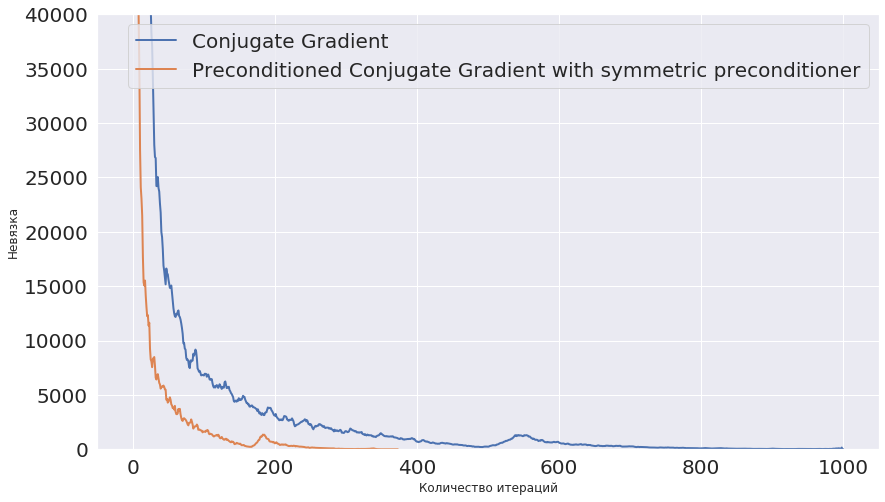

In [59]:
sns.set()

x_cg = np.arange(len(er_cg))
x_pcg_sym = np.arange(len(er_pcg_sym))

plt.figure(figsize = (14, 8))
plt.plot(x_cg, er_cg,  linewidth=2, label='Conjugate Gradient')
plt.plot(x_pcg_sym, er_pcg_sym, linewidth=2, 
         label='Preconditioned Conjugate Gradient with symmetric preconditioner')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(-2, 4*10**4)
plt.legend(loc="best", fontsize=20)
plt.xlabel('Количество итераций')
plt.ylabel('Невязка')
plt.show()

Сравните результат работы предобусловленной и непредобусловленной версии

**Вывод:**
Предобусловленная версия сходится намного быстрее не предобусловленной.

## Второе задание. Метод момента

Реализовать Метод момента.

![](Momentum.png)

([Картинка отсюда](https://cs231n.github.io/neural-networks-3/))

Сравнить его с методом Нестерова и методом градиентного спуска, которые были преддставлены на семинаре. Сравнивать можно на $2D$  задаче с семинара

In [52]:
import types
def backtracking (x, f, grad_f, rho, alpha0, beta1, beta2):
    
    alpha = alpha0
    if isinstance(grad_f ,types.FunctionType):
        phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
        phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
        f_k = f(x - alpha * grad_f(x)) 
    else:
        phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
        phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
        f_k = f(x - alpha * grad_f) 

    while not ((f_k <=phi1) and 
              (f_k >=phi2)):
        alpha *= rho
        
        if isinstance(grad_f ,types.FunctionType):
            phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
            phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
            f_k = f(x - alpha * grad_f(x)) 
        else: 
            phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
            phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
            f_k = f(x - alpha * grad_f) 
        if alpha < 1e-17:

            return alpha / rho

    return alpha

def GradientDescent(f, gradf, x0, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = []

  
    while True:

        beta2 = 1. -beta1
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        x = x - alpha * gradient
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res


def NesterovAcceleratedGD(f, gradf, x0, momentum =0.9, max_iter=1000, tol=1e-8,  rho=0.5, beta1=0.2):
    x = x0.copy()
    iteration = 0
    conv_array = []

    change = np.zeros(x.shape)
   
    while True:

        beta2 = 1. -beta1
        proj = x + momentum * change
        
        gradient = gradf(proj)
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        change = momentum * change - alpha * gradient
        x = x  + change
        
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

def MomentumGradientDescent(f, gradf, x0, koef_momentum=0.4, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = []
    momentum = 0
  
    while True:

        beta2 = 1. -beta1
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        x = x - alpha * gradient - alpha*koef_momentum*momentum
        momentum = koef_momentum * momentum + (1 - koef_momentum) * gradient
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res


def  get_x_y_from_callback(array, x0):
    x_array = [x0[0]]
    y_array = [x0[0]]
    for el in array:
        x_array.append(el[0])
        y_array.append(el[1])
        
    return np.array(x_array), np.array(y_array)

In [23]:
sns.set()
np.random.seed(23)
n=100
# строим и нормализуем матрицу
A = np.array([[4,3], [3,4]])
U = np.random.rand(2, 2)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5

n_points = 100

u = np.linspace(-4, 4, n_points)
x, y = np.meshgrid(u, u)
b = np.random.rand(2)
X = np.vstack([x.flatten(), y.flatten()])

# строим изолинии
f_x = X.T @ A @ X - b @ X

f_x = np.diag(f_x).reshape(n_points, n_points)


# b I used  in my own experiments array([0.22104536, 0.68622209]) 

# начальное приближение
x0 = np.array([-4. , -4.])


# вспомогательные функции для кастомного Gradient DEscent
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b

In [53]:
res_nest = NesterovAcceleratedGD(f, grad_f, x0, )
x_na, y_na = get_x_y_from_callback(res_nest["conv_array"], x0)

res = GradientDescent(f, grad_f, x0, rho=0.5, beta1=0.2)
x_gd, y_gd = get_x_y_from_callback(res['conv_array'], x0)

mom_res = MomentumGradientDescent(f, grad_f, x0, rho=0.5, beta1=0.2)
x_momgd, y_momgd = get_x_y_from_callback(mom_res['conv_array'], x0)

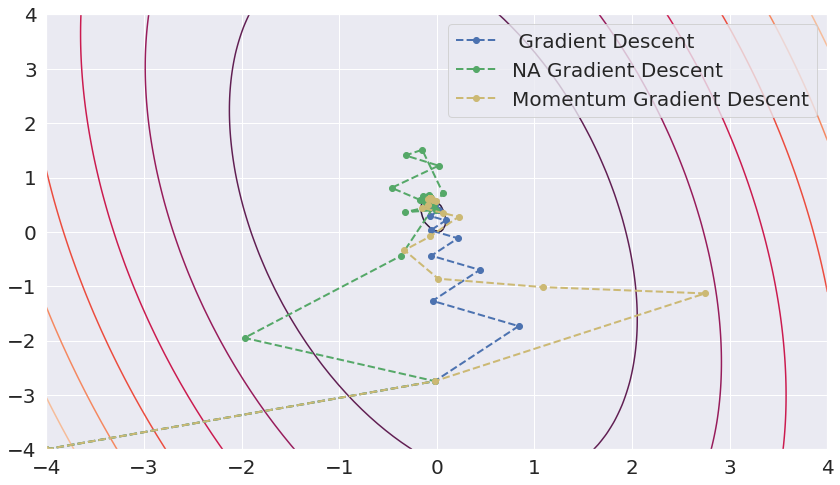

In [55]:
plt.figure(figsize = (14, 8))


plt.plot(x_gd, y_gd, '--bo',linewidth=2, label=' Gradient Descent')

plt.plot(x_na, y_na ,'--go', linewidth=2, label='NA Gradient Descent')

plt.plot(x_momgd, y_momgd ,'--yo', linewidth=2, label='Momentum Gradient Descent')

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc="best", fontsize=20)
plt.contour(x, y, f_x)
plt.show()

**Вывод:**
Метод моментов получается чем-то средним между обычным градиентным спуском и методом Нестерова в зависимости от коээфициента с которым мы учитываем импульс. Чем больше этот коэффициент тем больше его колбасит, а чем меньше, тем больше он похож на градиентный спуск